In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import argparse
import torch
import torchvision
import torch.nn.functional as F
import numpy as np

from nn.enums import ExplainingMethod
from nn.networks import ExplainableNet
from nn.utils import get_expl, plot_overview, clamp, load_image, make_dir
import matplotlib.pyplot as plt
%matplotlib inline

no display found. Using non-interactive Agg backend


In [3]:
def show(img):
    plt.tick_params(
        which='both',      # both major and minor ticks are affected
        left = False,
        right = False,
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False,
        labelbottom=False) # labels along the bottom edge are off
    if len(img.shape)==2:
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img)

In [4]:
def get_beta(i, num_iter):
    """
    Helper method for beta growth
    """
    start_beta, end_beta = 10.0, 100.0
    return start_beta * (end_beta / start_beta) ** (i / num_iter)

def np_img_to_tensor(input_sample, num_ch):
    if num_ch == 1:
        rgb_img = np.repeat(input_sample[..., np.newaxis], 3, -1)
    else:
        rgb_img = input_sample
    im = Image.fromarray(rgb_img)
    x = torchvision.transforms.Normalize(mean=data_mean, std=data_std)(torchvision.transforms.ToTensor()(torchvision.transforms.Resize(224)(im)))
    x = x.unsqueeze(0).to(device)
    return x

In [5]:
args_cuda = True

# choices:['lrp', 'guided_backprop', 'gradient', 'integrated_grad','pattern_attribution', 'grad_times_input']
args_method = 'lrp'
args_beta_growth = None
args_img = '../data/collie4.jpeg'
args_target_img = '../data/tiger_cat.jpeg'
args_num_iter = 1500
args_prefactors = [1e11, 1e6]
args_lr = 0.0002
args_output_dir = '../output/'
args_dataset ='fmnist'

In [10]:
# options
device = torch.device("cuda" if args_cuda else "cpu")
# load model
# data_mean = np.array([0.485, 0.456, 0.406])
# data_std = np.array([0.229, 0.224, 0.225])

if args_dataset=='fmnist' or args_dataset == 'mnist':
    data_mean = np.array([0.0, 0.0, 0.0])
    data_std = np.array([1.0,1.0, 1.0])

elif args_dataset=='cifar':
    data_mean = np.array([0.0, 0.0, 0.0])
    data_std = np.array([1.0,1.0, 1.0])
#     data_mean = np.array([0.4914, 0.4822, 0.4465])
#     data_std = np.array([0.2023, 0.1994, 0.201])



In [7]:
method = getattr(ExplainingMethod, args_method)
print('Explanation method {} will be used'.format(method))



vgg_model = torchvision.models.vgg16(pretrained=True)
model = ExplainableNet(vgg_model, data_mean=data_mean, data_std=data_std, beta=1000 if args_beta_growth else None)
if method == ExplainingMethod.pattern_attribution:
    model.load_state_dict(torch.load('../models/model_vgg16_pattern_small.pth'), strict=False)
model = model.eval().to(device)

#print(vgg_model)

Explanation method ExplainingMethod.lrp will be used


In [ ]:
# load images
x = load_image(data_mean, data_std, device, args_img)
x_target = load_image(data_mean, data_std, device, args_target_img)
x_adv = x.clone().detach().requires_grad_()

In [ ]:
x.requires_grad = True
_, class_idx = model.classify(x)
print('class_idx of dog: ',class_idx)

_, target_class_idx = model.classify(x_target)
print('class_idx of cat: ', target_class_idx)

In [ ]:

org_expl, _, _ = get_expl(model, x, method, class_idx)
org_expl_as_target, _, _ = get_expl(model, x, method, target_class_idx)


target_expl, _, _ = get_expl(model, x_target, method, target_class_idx)
target_expl_as_orig, _, _ = get_expl(model, x_target, method, class_idx)

org_expl = org_expl.detach()
org_expl_as_target = org_expl_as_target.detach()
target_expl = target_expl.detach()
target_expl_as_orig = target_expl_as_orig.detach()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
org_expl_np = org_expl.cpu().numpy()
plt.imshow(org_expl_np[0])

In [ ]:
org_expl_as_target_np = org_expl_as_target.cpu().numpy()
plt.imshow(org_expl_as_target_np[0])

In [ ]:
target_expl_np = target_expl.cpu().numpy()
plt.imshow(target_expl_np[0])

In [ ]:
target_expl_as_orig_np = target_expl_as_orig.cpu().numpy()
plt.imshow(target_expl_as_orig_np[0])

# Plot a normal example and its explanations

In [8]:
import keras
from keras import datasets 
from torchvision import datasets, transforms
from PIL import Image

if args_dataset == 'fmnist':
    (x_train, y_train) ,(x_test, y_test) = keras.datasets.fashion_mnist.load_data()
    num_ch = 1
elif args_dataset == 'mnist':
    (x_train, y_train) ,(x_test, y_test) = keras.datasets.mnist.load_data()
    num_ch = 1

Using TensorFlow backend.
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [32]:
class_idx = 3
indices = np.where(y_train == class_idx)[0]
choice = 70
idx = indices[choice]

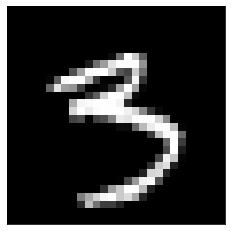

In [33]:
show(x_train[idx])

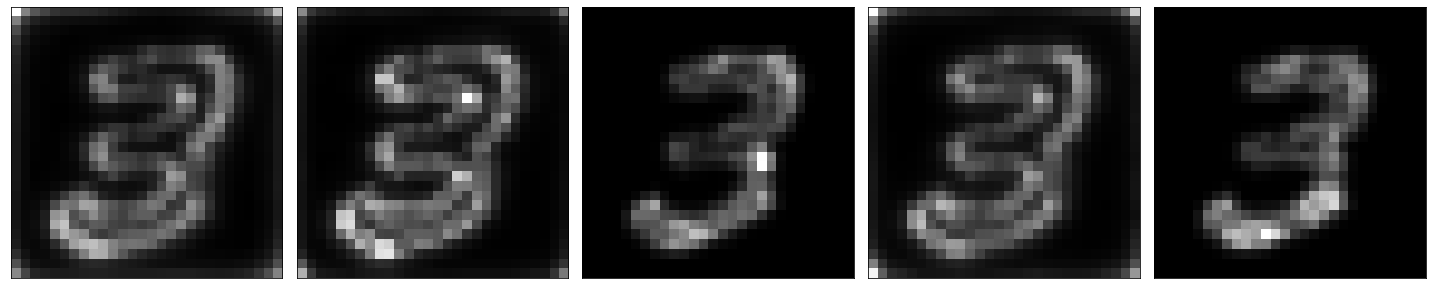

In [11]:
num_exp_methods = 5
side = 28
expls = np.empty((num_exp_methods, side, side))
device = torch.device("cuda" if args_cuda else "cpu")

for i, exp_method in enumerate(['lrp', 'guided_backprop', 'integrated_grad','pattern_attribution', 'grad_times_input']):
    method = getattr(ExplainingMethod, exp_method)
    
    vgg_model = torchvision.models.vgg16(pretrained=True)
    model = ExplainableNet(vgg_model, data_mean=data_mean, data_std=data_std, beta=1000 if args_beta_growth else None)
    if method == ExplainingMethod.pattern_attribution:
        model.load_state_dict(torch.load('../models/model_vgg16_pattern_small.pth'), strict=False)
    model = model.eval().to(device)
    
    
    x = np_img_to_tensor(x_train[idx], num_ch)
    x_adv = x.clone().detach().requires_grad_()
    
    org_expl, org_acc, org_idx = get_expl(model, x, method)
    org_expl = org_expl.detach().cpu()
    
    xnp = org_expl.numpy()
    xnp = xnp.reshape(224, 224)
    im2 = Image.fromarray(xnp)
    x_new = torchvision.transforms.ToTensor()(torchvision.transforms.Resize(28)(im2))
    x_new_np = x_new.numpy()
    x_new_np = x_new_np.reshape(28,28)
    
    expls[i] = x_new_np


n = num_exp_methods
plt.figure(figsize=(20,90))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(expls[i])
    if args_dataset == 'fmnist' or args_dataset == 'mnist':
        plt.gray()
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.gray()
plt.tight_layout()
plt.show()

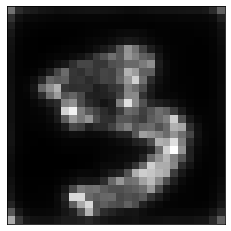

In [34]:
num_exp_methods = 1
side = 28
expls = np.empty((num_exp_methods, side, side))
device = torch.device("cuda" if args_cuda else "cpu")

for i, exp_method in enumerate(['guided_backprop']):
    method = getattr(ExplainingMethod, exp_method)
    
    vgg_model = torchvision.models.vgg16(pretrained=True)
    model = ExplainableNet(vgg_model, data_mean=data_mean, data_std=data_std, beta=1000 if args_beta_growth else None)
    if method == ExplainingMethod.pattern_attribution:
        model.load_state_dict(torch.load('../models/model_vgg16_pattern_small.pth'), strict=False)
    model = model.eval().to(device)
    
    
    x = np_img_to_tensor(x_train[idx], num_ch)
    x_adv = x.clone().detach().requires_grad_()
    
    org_expl, org_acc, org_idx = get_expl(model, x, method)
    org_expl = org_expl.detach().cpu()
    
    xnp = org_expl.numpy()
    xnp = xnp.reshape(224, 224)
    im2 = Image.fromarray(xnp)
    x_new = torchvision.transforms.ToTensor()(torchvision.transforms.Resize(28)(im2))
    x_new_np = x_new.numpy()
    x_new_np = x_new_np.reshape(28,28)
    
    expls[i] = x_new_np


show(expls[i])

# Plot a source example, adversarial example, and explanation of adversarial examples

In [10]:
if class_idx == 0:
    src_class_idx = 9
else:
    src_class_idx = class_idx-1

In [11]:
attack_method = 'mim'
adv_dir = '../../xai-adv/data/postndss/defender/'+args_dataset+'/target_next/target_' + str(class_idx) + '/' + attack_method + '/'
adv = np.load(adv_dir+'x_adv_ar.npy')
indices_of_src = np.where(y_train == src_class_idx)[0]


This is the source example from which adv example was created


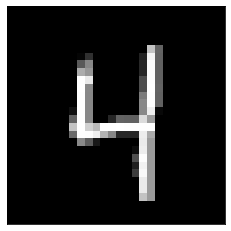

In [14]:
choice = 10
idx = indices_of_src[choice]
print('This is the source example from which adv example was created')
show(x_train[idx]) 

This is the adv example from which explanation will be created


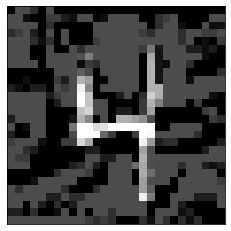

In [15]:
print('This is the adv example from which explanation will be created')
show(adv[choice])

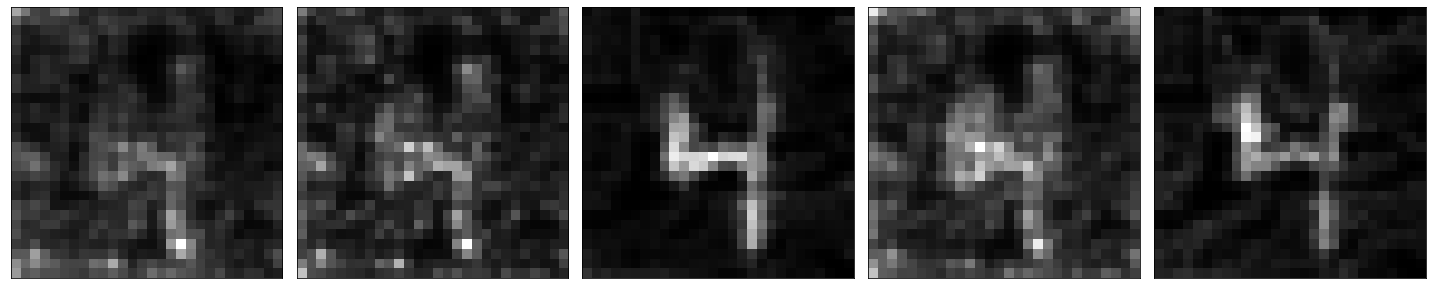

In [29]:
import random
num_exp_methods = 5
side = 28
expls = np.empty((num_exp_methods, side, side))
device = torch.device("cuda" if args_cuda else "cpu")
desired_index = random.randint(0,999)

adv_sample = adv[choice]
adv_sample = adv_sample * 255
adv_sample = adv_sample.astype(np.uint8)

for i, exp_method in enumerate(['lrp', 'guided_backprop', 'integrated_grad','pattern_attribution', 'grad_times_input']):
    method = getattr(ExplainingMethod, exp_method)
    
    vgg_model = torchvision.models.vgg16(pretrained=True)
    model = ExplainableNet(vgg_model, data_mean=data_mean, data_std=data_std, beta=1000 if args_beta_growth else None)
    if method == ExplainingMethod.pattern_attribution:
        model.load_state_dict(torch.load('../models/model_vgg16_pattern_small.pth'), strict=False)
    model = model.eval().to(device)
    
    
    x = np_img_to_tensor(adv_sample, num_ch)
    x_adv = x.clone().detach().requires_grad_()
    
    org_expl, org_acc, org_idx = get_expl(model, x, method, desired_index)
    org_expl = org_expl.detach().cpu()
    
    xnp = org_expl.numpy()
    xnp = xnp.reshape(224, 224)
    im2 = Image.fromarray(xnp)
    x_new = torchvision.transforms.ToTensor()(torchvision.transforms.Resize(28)(im2))
    x_new_np = x_new.numpy()
    x_new_np = x_new_np.reshape(28,28)
    
    expls[i] = x_new_np


n = num_exp_methods
plt.figure(figsize=(20,90))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(expls[i])
    if args_dataset == 'fmnist' or args_dataset == 'mnist':
        plt.gray()
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.gray()
plt.tight_layout()
plt.show()

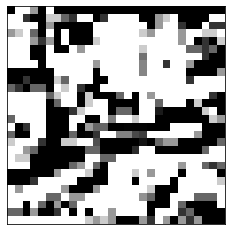

In [30]:
src_img = x_train[idx]
src_img = src_img/255.
adv_sample = adv[choice]

pert = abs(adv_sample-src_img)
show(pert)

# Play

In [ ]:
import keras
from keras import datasets 
(x_train, y_train) ,(x_test, y_test) = datasets.fashion_mnist.load_data()
from torchvision import datasets, transforms
from PIL import Image

x = np_img_to_tensor(x_train[0])
x_adv = x.clone().detach().requires_grad_()
print(x.shape)
org_expl, org_acc, org_idx = get_expl(model, x, method)
org_expl = org_expl.detach().cpu()

# The class from which we will derive the target explanation
source_class_idx = 6
# pick index of x_train where the label is that of the source class
idx = np.where(y_train == source_class_idx)[0][0]
grayscale_img_src = x_train[idx]
x_target = np_img_to_tensor(grayscale_img_src)
target_expl, _, _ = get_expl(model, x_target, method)
target_expl = target_expl.detach()

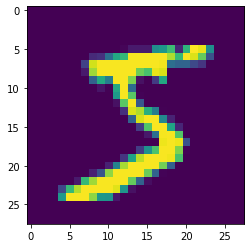

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_train[0])

In [ ]:
org_expl_np = org_expl.cpu().numpy()
plt.imshow(org_expl_np[0])

In [ ]:
plt.imshow(grayscale_img_src)

In [ ]:
target_expl_np = target_expl.cpu().numpy()
plt.imshow(target_expl_np[0])

# Exploration with Cifar

## Cifar_Normal 

In [5]:
import keras
from keras import datasets 
(x_train, y_train) ,(x_test, y_test) = datasets.cifar10.load_data()

Using TensorFlow backend.
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [12]:
from torchvision import datasets, transforms
from PIL import Image

idx = 0
x = np_img_to_tensor(x_train[idx], num_ch=3)
x_adv = x.clone().detach().requires_grad_()
print(x.shape)

org_expl, org_acc, org_idx = get_expl(model, x, method)
org_expl = org_expl.detach().cpu()

torch.Size([1, 3, 224, 224])


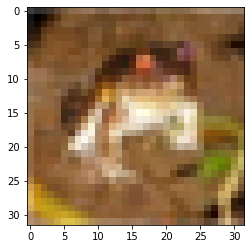

In [13]:
plt.imshow(x_train[idx])

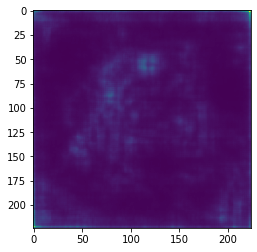

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
org_expl_np = org_expl.cpu().numpy()
plt.imshow(org_expl_np[0])

In [23]:
org_expl.shape

torch.Size([1, 224, 224])

In [15]:
org_expl_np = org_expl.numpy()
org_expl_np = org_expl_np.reshape(224, 224)
im2 = Image.fromarray(org_expl_np)
org_expl2 = torchvision.transforms.ToTensor()(torchvision.transforms.Resize(32)(im2))
org_expl_np2 = org_expl2.numpy()
org_expl_np2 = org_expl_np2.reshape(32,32)

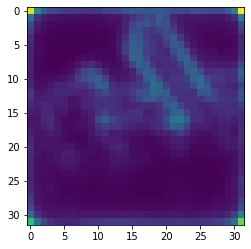

In [11]:
plt.imshow(org_expl_np2)

## Cifar_Abnormal

In [4]:
adv_dir = '../../xai-adv/data/postndss/{}/{}/target_next/target_{}/{}/'
adv_dir = adv_dir.format('defender', 'cifar10', '0', 'cwl2/conf_0')
x_train = np.load(adv_dir + '/x_adv_ar.npy')
print('Loading {} adv samples from {} '.format(x_train.shape[0],adv_dir))
print(np.min(x_train[0]))
print(np.max(x_train[0]))

Loading 1000 adv samples from ../../xai-adv/data/postndss/defender/cifar10/target_next/target_0/cwl2/conf_0/ 
0.0019288361072540283
0.9997408986091614


In [5]:
x_train = (x_train*255).astype(np.uint8)

## Plot noisy example and its explanation

In [10]:
dataset = 'fmnist'

import keras
from keras import datasets 
from torchvision import datasets, transforms
from PIL import Image

if args_dataset == 'fmnist':
    (x_train, y_train) ,(x_test, y_test) = keras.datasets.fashion_mnist.load_data()
    num_ch = 1
elif args_dataset == 'mnist':
    (x_train, y_train) ,(x_test, y_test) = keras.datasets.mnist.load_data()
    num_ch = 1

x_noised = np.load('../../xai-adv/' + 'data/postndss/defender/'+ dataset +'/with_noise/x_noised.npy')
print('x_noised shape: ',x_noised.shape)

In [29]:
# Select a class index. We will show normal and noisy examples of this class
class_ind = 7
indices = np.where(y_test == class_ind)[0]
print(indices[0:10])

[ 9 12 22 36 38 43 45 60 61 70]


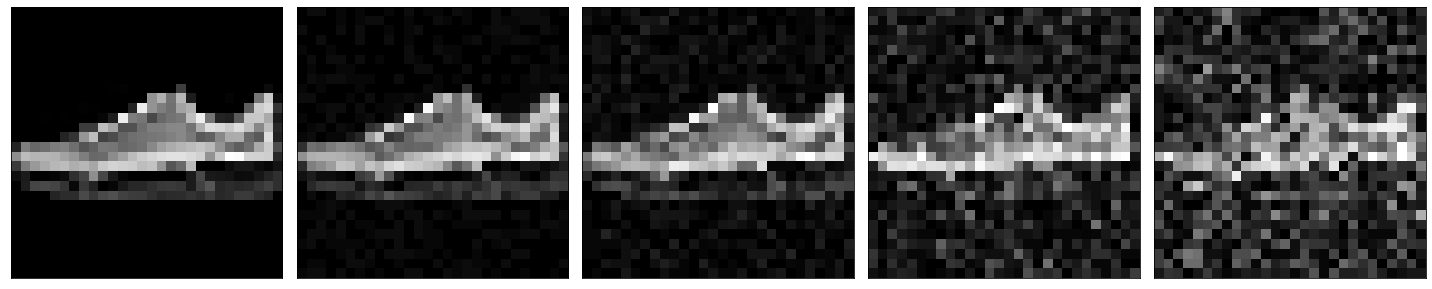

In [46]:
# select position of the example (can be anything depending upon the number of examples of this class)
pos = 0
n = x_noised.shape[0]+1

samples = np.empty((5, 28, 28))
for i in range(n):
    if i == 0:
        samples[i] = x_test[indices[pos]]
    else:
        samples[i] = x_noised[i-1][indices[pos]].reshape(28,28) * 255        

plt.figure(figsize=(20,90))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(samples[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.gray()
plt.tight_layout()
plt.show()

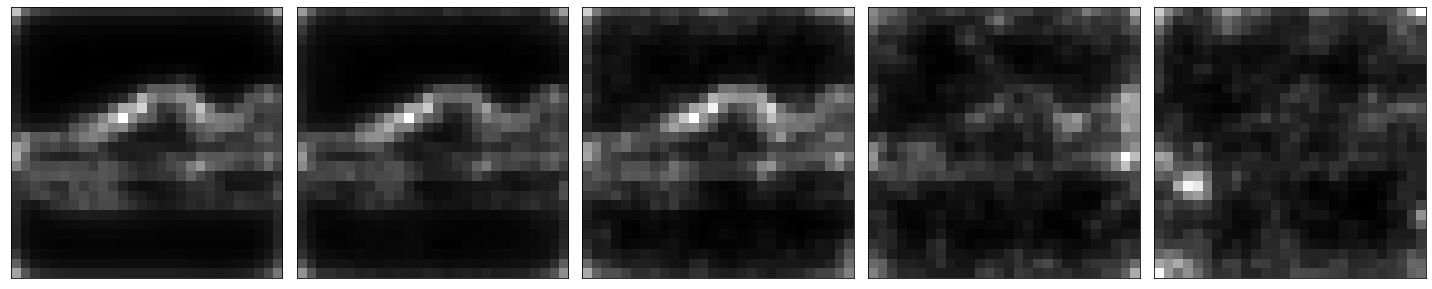

In [49]:
expls = np.empty((5, 28, 28))
num_ch = 1
device = torch.device("cuda" if args_cuda else "cpu")
exp_method = 'lrp'
method = getattr(ExplainingMethod, exp_method)

vgg_model = torchvision.models.vgg16(pretrained=True)
model = ExplainableNet(vgg_model, data_mean=data_mean, data_std=data_std, beta=1000 if args_beta_growth else None)
if method == ExplainingMethod.pattern_attribution:
    model.load_state_dict(torch.load('../models/model_vgg16_pattern_small.pth'), strict=False)
model = model.eval().to(device)
for i in range(n):
    sample = samples[i].astype(np.uint8)
    x = np_img_to_tensor(sample, num_ch)
    org_expl, org_acc, org_idx = get_expl(model, x, method)
    org_expl = org_expl.detach().cpu()
    
    xnp = org_expl.numpy()
    xnp = xnp.reshape(224, 224)
    im2 = Image.fromarray(xnp)
    x_new = torchvision.transforms.ToTensor()(torchvision.transforms.Resize(28)(im2))
    x_new_np = x_new.numpy()
    x_new_np = x_new_np.reshape(28,28)
    
    expls[i] = x_new_np

plt.figure(figsize=(20,90))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(expls[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.gray()
plt.tight_layout()
plt.show()


# Supporting figures for whitebox illustration

In [7]:
import keras
from keras import datasets 
from torchvision import datasets, transforms
from PIL import Image
dataset = 'cifar10'
attack = 'cwl2/conf_0'
target_exp_method = 'lrp'

if dataset == 'fmnist':
    num_ch = 1
    side = 28

    (x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = keras.datasets.fashion_mnist.load_data()

elif dataset == 'mnist':
    num_ch = 1
    side = 28

    (x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = keras.datasets.mnist.load_data()

elif dataset == 'cifar10':
    num_ch = 3
    side = 32
    
    (x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = keras.datasets.cifar10.load_data()

Using TensorFlow backend.
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/raj_vardhan/anaconda3/envs/torch_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

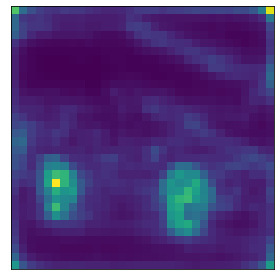

In [14]:
target_class_ind = 1
choice = 0
index = np.where(y_train_orig == target_class_ind)[0][choice]
target_img = x_train_orig[index]

expls = np.empty((1, 32, 32))
device = torch.device("cuda" if args_cuda else "cpu")
exp_method = 'lrp'
method = getattr(ExplainingMethod, exp_method)

vgg_model = torchvision.models.vgg16(pretrained=True)
model = ExplainableNet(vgg_model, data_mean=data_mean, data_std=data_std, beta=1000 if args_beta_growth else None)

if method == ExplainingMethod.pattern_attribution:
    model.load_state_dict(torch.load('../models/model_vgg16_pattern_small.pth'), strict=False)
model = model.eval().to(device)

sample = target_img.astype(np.uint8)
x = np_img_to_tensor(sample, num_ch)
org_expl, org_acc, org_idx = get_expl(model, x, method)
org_expl = org_expl.detach().cpu()

xnp = org_expl.numpy()
xnp = xnp.reshape(224, 224)
im2 = Image.fromarray(xnp)
x_new = torchvision.transforms.ToTensor()(torchvision.transforms.Resize(32)(im2))
x_new_np = x_new.numpy()
x_new_np = x_new_np.reshape(32, 32)

expls[0] = x_new_np

ax = plt.subplot(1, 1,1)
plt.imshow(expls[0])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

In [15]:
np.save('../output/whitebox_illustration/target_map.npy', expls[0])